# Relax Inc. Data Science Challenge

#### Objective: Identify which factors predict future user adoption.

### Import libraries and modify notebook settings

In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier

# Modify notebook settings
%matplotlib inline
sns.set(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create paths to data folders and files

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

filepath_user_engagement = os.path.join('relax_challenge',
                                        'takehome_user_engagement.csv')

filepath_users = os.path.join('relax_challenge',
                              'takehome_users.csv')

# Save the path to the folder that will contain the final dataset:
# /data/processed
processed_data_dir = os.path.join(proj_root, "data", "processed")

# Save path to the `models` folder
models_folder = os.path.join(proj_root, "models")

### Read in raw data

In [3]:
df_user_engagement = pd.read_csv(filepath_user_engagement)
df_users = pd.read_csv(filepath_users, index_col=0, encoding='latin-1')

In [4]:
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df_users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
df_user_engagement.shape

(207917, 3)

In [7]:
df_users.shape

(12000, 9)

# Wrangling

Convert 'time_stamp' dtype to datetime type

In [8]:
df_user_engagement['time_stamp'] = \
pd.to_datetime(df_user_engagement['time_stamp'])

We care about dates, not hour, minute, second, etc.

In [9]:
df_user_engagement['time_stamp'] = \
df_user_engagement['time_stamp'].dt.date

Does 'visited' column contain any valuable information?

In [10]:
df_user_engagement['visited'].value_counts()

1    207917
Name: visited, dtype: int64

No. This column contains only the value 1.  We will drop it.

In [11]:
df_user_engagement.drop('visited', axis=1, inplace=True)

### Engineer the target variable

An "adopted user" here is defined as a user who has logged into the product on three separate days in at least one seven-day period.

We engineer a binary target variable for whether or not a user is an "adopted user"

In [12]:
day_dif = (df_user_engagement['time_stamp'] - 
           df_user_engagement.shift(periods=1)['time_stamp'])

day_dif = day_dif.dt.days

user_same_mask = (df_user_engagement.shift(periods=1)['user_id'] \
                  == df_user_engagement['user_id'])

day_dif.is_copy = False
day_dif[~user_same_mask] = np.nan

df_user_engagement['day_dif'] = day_dif

df_user_engagement['rolling_day_sum'] = \
    df_user_engagement['day_dif'].rolling(3).sum()
    
adopted_users = (df_user_engagement.\
                 groupby(by='user_id')['rolling_day_sum'].\
                 min() <= 7)

adopted_users = adopted_users.to_frame(name='adopted')

df_joined = adopted_users.join(df_users, how='outer')

df_joined.index.name = 'object_id'

df_joined['adopted'].fillna(False, inplace=True)

df_joined['adopted'] = df_joined['adopted'].astype(int)

### Feature engineering

In [13]:
df_joined['creation_time'] = pd.to_datetime(df_joined['creation_time'])

df_joined.is_copy = False

df_joined['creation_hour'] = df_joined['creation_time'].dt.hour

df_joined['creation_month'] = df_joined['creation_time'].dt.month

df_joined['creation_year'] = df_joined['creation_time'].dt.year

In [14]:
df_temp = df_joined[['adopted']].reset_index()
df_temp = df_temp[df_temp['adopted'] == 1]

adopted = (df_joined[df_joined['invited_by_user_id'].\
                     notnull()]['invited_by_user_id'].\
           astype(int))

df_joined['invited_by_adopted_user'] = (df_joined['invited_by_user_id'].\
                                        isin(adopted).astype(int))

In [15]:
df_joined['days_spanned'] = \
(pd.to_datetime(df_users['last_session_creation_time'],
                unit='s') - df_joined['creation_time']).dt.days

df_joined['days_spanned'].fillna(0, inplace=True)

### EDA

In [16]:
df_joined['adopted'].value_counts(normalize=True)

0    0.888417
1    0.111583
Name: adopted, dtype: float64

### Create a dataset for the ML pipeline

In [17]:
df_final = df_joined[['adopted',
                      'opted_in_to_mailing_list',
                      'enabled_for_marketing_drip',
                      'last_session_creation_time',
                      'creation_hour',
                      'creation_month',
                      'creation_year',
                      'days_spanned']]

In [18]:
df_final.head()

,adopted,opted_in_to_mailing_list,enabled_for_marketing_drip,last_session_creation_time,creation_hour,creation_month,creation_year,days_spanned
object_id,,,,,,,,
1,0,1,0,1.398139e+09,3,4,2014,0.0
2,0,0,0,1.396238e+09,3,11,2013,136.0
3,0,0,0,1.363735e+09,23,3,2013,0.0
4,0,0,0,1.369210e+09,8,5,2013,1.0
5,0,0,0,1.358850e+09,10,1,2013,5.0


## ML Pipeline

### Train test split

In [19]:
df = df_final

In [20]:
# Extract X and y from df
X = df.drop('adopted', axis=1).values
y = df['adopted'].values

# Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

#### Define the pipeline

In [21]:
# Create pipeline
pipe = Pipeline([('classifier', 
                  XGBClassifier(objective='binary:logistic'))])

# Create parameter grid
param_grid = [
    {'classifier': [XGBClassifier(objective='binary:logistic')], 
     'classifier__n_estimators': [100, 1000]}]

#### Perform the grid search

In [22]:
# Set verbosity
verbosity = 1

# Execute Grid search
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc',
                    verbose=verbosity)#, n_jobs=cores_used)

# Set seed for reproducibility
np.random.seed(42)

# Fit the grid search object
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.3s finished


Best params:
{'classifier': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1), 'classifier__n_estimators': 100}

Best cross-validation score: 0.995


### Analyse model results

In [23]:
clf = grid.best_estimator_

In [24]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.99705331856354729

In [25]:
confusion_matrix(y_train, clf.predict(X_train))

array([[7408,   54],
       [  87,  851]])

In [26]:
confusion_matrix(y_test, clf.predict(X_test))

array([[3165,   34],
       [  33,  368]])

In [27]:
accuracy_score(y_train, clf.predict(X_train))

0.98321428571428571

In [28]:
accuracy_score(y_test, clf.predict(X_test))

0.98138888888888887

Feature Importance

In [29]:
features_importance = pd.Series(clf.steps[0][1].feature_importances_,
                                index=df.drop('adopted', axis=1).columns)

features_importance.sort_values(ascending=False, inplace=True)

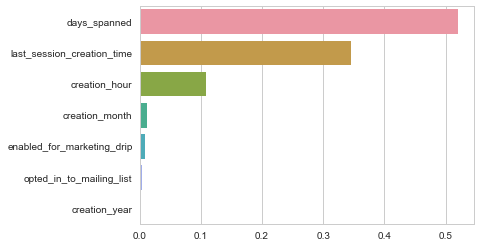

In [30]:
sns.barplot(y=features_importance.index,
            x=features_importance.values)

# Save the figure
plt.savefig('feature_importance', dpi = 300, bbox_inches='tight')

In [31]:
df_gb = (df.sample(frac=0.7,random_state=42).\
         groupby(by=['days_spanned',
                     'adopted'])['days_spanned'].count().unstack())
df_gb.fillna(0, inplace=True)

df_proportions = pd.DataFrame(df_gb[1].div(df_gb.sum(axis=1)))
df_proportions.rename(columns={0: "Proportion Adopted"}, inplace=True)
df_proportions.reset_index(inplace=True)

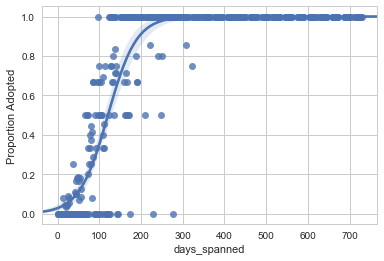

In [32]:
sns.regplot(x="days_spanned", y="Proportion Adopted", 
            data=df_proportions, logistic=True, 
            n_boot=500, y_jitter=.00)

plt.savefig('days_spanned_graph', dpi = 300, bbox_inches='tight')